In [1]:
import pandas as pd
import os

In [2]:
topic = 'abortion'
scheme = 'NNPred'

path = os.getcwd()
clean_path = f'{path}/clean/multiclass'
NN_path = f'{path}/NN/multiclass/{topic}/{scheme}'

train_file = f'{path}/train/labeled_{topic}_NNtrain.csv'
test_file = f'{path}/test/labeled_{topic}_test.csv'

os.makedirs(NN_path, exist_ok=True)
os.makedirs(f'{clean_path}/train', exist_ok=True)
os.makedirs(f'{clean_path}/test', exist_ok=True)

NN_path

'/media/rinnely/Archer/ENES/Stance/Clasificador/NN/multiclass/abortion/NNPred'

In [ ]:
train = pd.read_csv(train_file)

In [ ]:
train.head()

In [ ]:
train = train[[f'{scheme}', 'Tweet']]
train.columns = ['Label', 'Tweet']

In [ ]:
train.head()

In [ ]:
train.Label.unique()

In [ ]:
#train = train.query('Label != 0')
train.Label.unique()

In [ ]:
train.groupby('Label').count()

In [ ]:
test = pd.read_csv(test_file)
test.head()

In [19]:
test = test[['Stance', 'Tweet']]
test.Stance.unique()

KeyError: "['Stance'] not in index"

In [ ]:
test['Stance']= test.Stance.replace({'FAVOR':1, 'AGAINST':-1, 'NONE':0})
#test = test.query('Stance != 0')
test.Stance.unique()

In [ ]:
test.columns = ['Label', 'Tweet']
test.groupby('Label').count()

In [ ]:
train.shape, test.shape

# clean data

In [ ]:
import sys
sys.path.insert(0, '/media/rinnely/Archer/ENES/Stance')
import cleandata as cd

In [ ]:
train = cd.cleanData(train.copy(), label='Tweet', hashtags=True, urls='URL', emojis=True, users='USER')
test = cd.cleanData(test.copy(), label='Tweet', hashtags=True, urls='URL', emojis=True, users='USER')

In [ ]:
train = train.dropna(axis=0)

# token

In [ ]:
import nltk
nltk.download('stopwords') 
from nltk.corpus import stopwords 

In [ ]:
stop_words = stopwords.words('english')

In [ ]:
tokenized_train = train['Tweet'].apply(lambda x: x.split())
tokenized_test = test['Tweet'].apply(lambda x: x.split())

In [ ]:
tokenized_test

In [ ]:
tokenized_train = tokenized_train.apply(lambda x:[item for item in x if 
                                    item not in stop_words]) 
tokenized_test = tokenized_test.apply(lambda x:[item for item in x if 
                                    item not in stop_words]) 

In [ ]:
tokenized_test

In [ ]:
train['detokens'] = tokenized_train.apply(lambda x: ' '.join(x))
test['detokens'] = tokenized_test.apply(lambda x: ' '.join(x))

In [ ]:
train

# save data

In [ ]:
train.to_csv(f'{clean_path}/train/clean_{topic}_{scheme}_train.csv', index=False)
test.to_csv(f'{clean_path}/test/clean_{topic}_{scheme}_test.csv', index=False)

# read data

In [3]:
train = pd.read_csv(f'{clean_path}/train/clean_{topic}_{scheme}_train.csv')
test = pd.read_csv(f'{clean_path}/test/clean_{topic}_{scheme}_test.csv')

<AxesSubplot:ylabel='Label'>

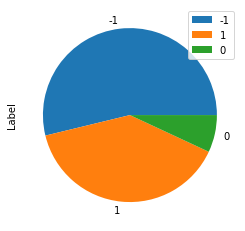

In [4]:
train['Label'].value_counts().plot.pie(legend=True)

<AxesSubplot:ylabel='Label'>

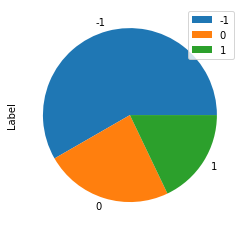

In [5]:
test['Label'].value_counts().plot.pie(legend=True)

<AxesSubplot:>

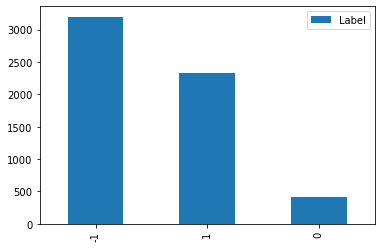

In [6]:
train['Label'].value_counts().plot.bar(legend=True)

<AxesSubplot:>

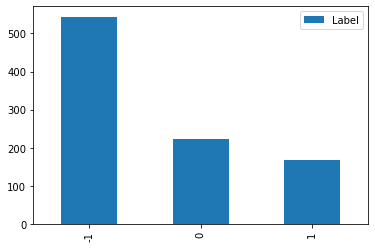

In [7]:
test['Label'].value_counts().plot.bar(legend=True)

In [8]:
train

,Label,Tweet
0,-1,#Abortion will never be approved on our soil!
1,1,A HUGE victory for #WomensRights as #Argentina...
2,-1,USER USER CULTURE OF LIFE for all #Georgians #...
3,-1,Dems are a death cult. They celebrate abortion...
4,-1,#Argentina became the largest country in #Lati...
...,...,...
5940,-1,#ProLife # International pro-life leaders expr...
5941,0,What drives women to have #abortions? URL
5942,-1,Common excuse: I will vote #ProLife on the res...
5943,-1,"I completely stand with Polands abortion ban, ..."


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5945 entries, 0 to 5944
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   5945 non-null   int64 
 1   Tweet   5945 non-null   object
dtypes: int64(1), object(1)
memory usage: 93.0+ KB


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 933 entries, 0 to 932
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   933 non-null    int64 
 1   Tweet   933 non-null    object
dtypes: int64(1), object(1)
memory usage: 14.7+ KB


In [11]:
train = train.dropna(axis=0)

In [ ]:
train.info()

# Training

In [12]:
from fastai.text import *

In [13]:
data_lm = (TextList.from_df(train, NN_path, cols='Tweet')
          .split_by_rand_pct(0.1)
          .label_for_lm() # this does the tokenization and numericalization
          .databunch())

/home/rinnely/anaconda3/lib/python3.8/site-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


In [ ]:
data_lm.show_batch()

In [14]:
data_clas = TextClasDataBunch.from_df(NN_path, train_df=train, 
                                      valid_df=test, 
                                      vocab=data_lm.vocab, 
                                      text_cols = 'Tweet', 
                                      label_cols = 'Label',
                                      bs=32)

/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
data_clas.show_batch()

In [ ]:
f'data_clas_{topic}_{scheme}'

In [15]:
data_lm.save(f'data_lm_{topic}_{scheme}')
data_clas.save(f'data_clas_{topic}_{scheme}')

In [16]:
data_lm.train_ds.vocab.itos[:10], len(data_lm.train_ds.vocab.itos)

(['xxunk',
  'xxpad',
  'xxbos',
  'xxeos',
  'xxfld',
  'xxmaj',
  'xxup',
  'xxrep',
  'xxwrep',
  '.'],
 3936)

In [17]:
#learn = ftxt.language_model_learner(data_lm, arch=ftxt.AWD_LSTM, drop_mult=.2)
learn_lm = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=.5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-02
Min loss divided by 10: 3.63E-02


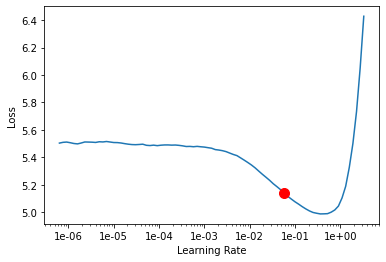

In [18]:
learn_lm.lr_find(); learn_lm.recorder.plot(suggestion=True)

In [20]:
learn_lm.fit_one_cycle(6,5e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.434772,3.727221,0.281250,00:13
1,3.949726,3.715003,0.291071,00:13
2,3.680272,3.698557,0.299963,00:14
3,3.410238,3.643703,0.305320,00:14
4,3.145122,3.609658,0.312909,00:14
5,2.943384,3.604869,0.313318,00:14


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 7.59E-04


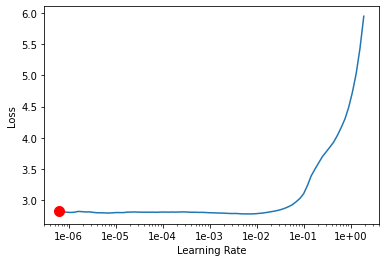

In [21]:
learn_lm.unfreeze()
learn_lm.lr_find(); learn_lm.recorder.plot(suggestion=True)

In [22]:
learn_lm.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,2.780820,3.579546,0.317262,00:19
1,2.721525,3.567874,0.321429,00:19
2,2.629924,3.580756,0.321801,00:20


In [23]:
learn_lm.save_encoder(f'{topic}_ml_encoder_v1')

In [24]:
learn_lm.load_encoder(f'{topic}_ml_encoder_v1');

In [25]:
learn_lm.save(f'{topic}_model_v1')

In [26]:
learn_lm.load(f'{topic}_model_v1');

In [27]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

In [28]:
from sklearn.metrics import f1_score

@np_func #converts torch tesnsor as numpy array
def f1_macro(inp, targ): 
    return f1_score(targ, np.argmax(inp, axis=1), labels=[0, 2], pos_label=None, average='macro')

In [29]:
learn.load_encoder(f'{topic}_ml_encoder_v1')
learn.metrics=[f1_macro]
learn.freeze()

In [30]:
learn.save('learner-1stage')

In [31]:
learn.load('learner-1stage');

epoch,train_loss,valid_loss,f1_macro,time


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-03
Min loss divided by 10: 3.02E-02


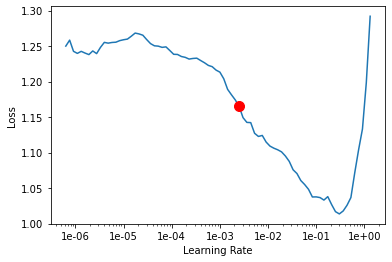

In [32]:
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [33]:
learn.fit_one_cycle(5,2e-3,moms=(0.8, 0.7))

epoch,train_loss,valid_loss,f1_macro,time
0,0.888538,1.278768,0.471683,00:11
1,0.754983,1.180226,0.532051,00:11
2,0.711202,1.125034,0.532999,00:11
3,0.655663,1.190112,0.539417,00:11
4,0.636032,1.191747,0.533050,00:12


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [34]:
learn.save('learner-2stage')

In [35]:
learn.load('learner-2stage');

epoch,train_loss,valid_loss,f1_macro,time


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.37E-05
Min loss divided by 10: 1.10E-03


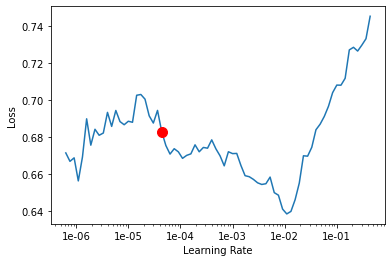

In [36]:
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [38]:
learn.fit_one_cycle(3, slice(4e-5/3,4e-5),moms=(0.8, 0.7))

epoch,train_loss,valid_loss,f1_macro,time
0,0.643822,1.217126,0.527443,00:11
1,0.629473,1.229814,0.522579,00:11
2,0.621458,1.196779,0.539606,00:11


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [39]:
learn.save('learner-3stage')

In [40]:
learn.load('learner-3stage');

In [ ]:
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(5, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,f1_macro,time


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-06
Min loss divided by 10: 1.45E-06


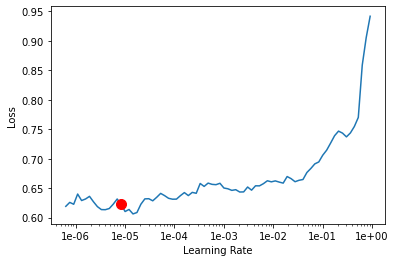

In [41]:
learn.freeze_to(-2)
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(5,6e-7,moms=(0.8, 0.7));

In [ ]:
learn.save('learner-stage-freeze-2')

In [ ]:
learn.save('learner-stage-freeze-2')

epoch,train_loss,valid_loss,f1_macro,time


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06
Min loss divided by 10: 1.10E-05


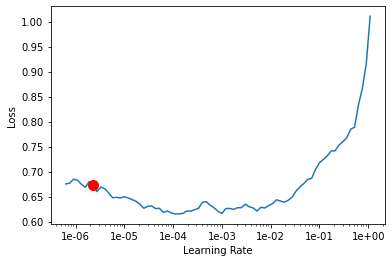

In [42]:
learn.freeze_to(-3)
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [43]:
learn.fit_one_cycle(3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,f1_macro,time
0,0.653128,1.301986,0.496793,00:24
1,0.610591,1.129400,0.574684,00:23
2,0.578292,1.134274,0.576839,00:24


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [44]:
learn.save('learner-stage-freeze-3')

In [45]:
learn.load('learner-stage-freeze-3');

epoch,train_loss,valid_loss,f1_macro,time


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


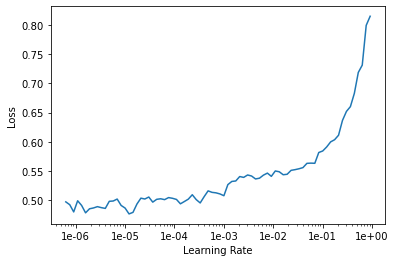

In [46]:
learn.unfreeze()
learn.lr_find(); learn.recorder.plot()

In [47]:
learn.fit_one_cycle(5, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,f1_macro,time
0,0.511051,1.141618,0.578590,00:31
1,0.440949,1.139144,0.575616,00:30
2,0.328777,1.207367,0.592575,00:32
3,0.253231,1.464443,0.579141,00:34
4,0.207304,1.440607,0.580831,00:33


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [48]:
learn.save('learner-stage-unfreeze-68')

In [49]:
learn.load('learner-stage-unfreeze-68');

In [50]:
preds, y, losses = learn.get_preds(with_loss=True)
interp = TextClassificationInterpretation(learn, preds, y, losses)

In [ ]:
interp.top_losses(10)

In [ ]:
interp.show_top_losses(10)

In [ ]:
interp.y_true.tolist()[:25]

In [ ]:
losses[598]

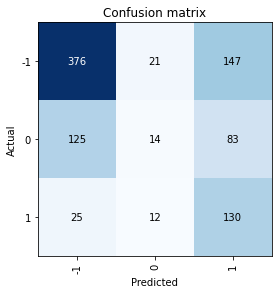

In [51]:
interp.plot_confusion_matrix()

In [ ]:
preds.numpy()[598]

In [ ]:
learn.save('learner-final')

In [ ]:
labels = np.argmax(preds, 1)
test_predictions_direct = [data.classes[int(x)] for x in labels]

In [ ]:
data_clas.show_batch

In [ ]:
learn.data.classes

In [ ]:
learn.data.one_item(10)

In [ ]:
data_clas.label_list[183]

In [ ]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [ ]:
for pred in preds:
    print(pred)
    for i,p in enumerate(pred):
        print(p)
        print(learn.data.classes[i])